# ARIMA

In [2]:
%pip install "pandas<3"



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot
from matplotlib.pylab import rcParams

In [4]:
rcParams['figure.figsize'] = 15, 6

The data contains a particular month and number of passengers traveling in that month. In order to read teh data as a time series, we have to pass special arguments to the read_csv() method.

In [5]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# df = pd.read_csv('../data_sets/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

df = pd.read_csv(
    '../data_sets/AirPassengers.csv',
    parse_dates=['Month'],
    index_col='Month'
)

In [6]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [8]:
# Convert to time series
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
ts['1949-01-01']

np.int64(112)

In [10]:
from datetime import datetime
ts[datetime(1949,1,1)]

np.int64(112)

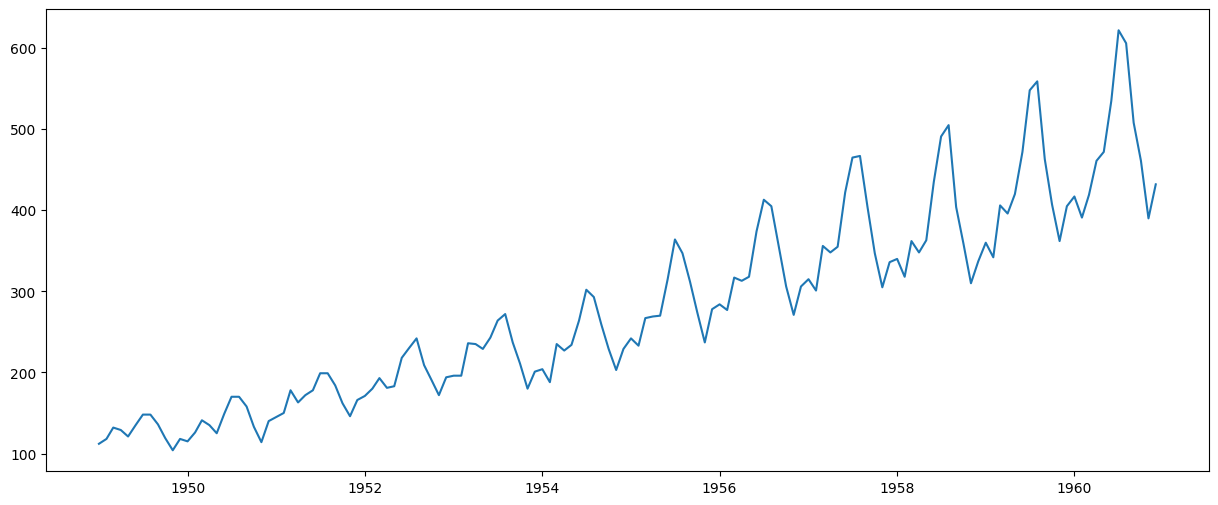

In [11]:
# Check Stationarity manually first
plt.plot(ts)

## Stationality Test (ADFuller)

In [12]:
import statsmodels
print(statsmodels.__version__)
from statsmodels.tsa.stattools import adfuller

0.14.5


In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller Test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

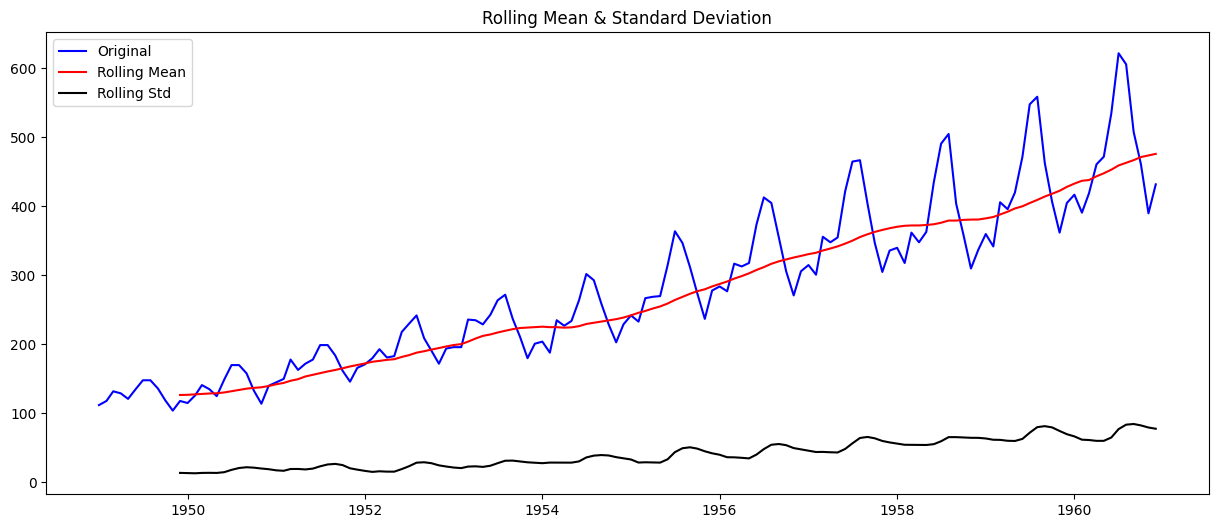

Results of Dickey-Fuller Test:
Test Statistics                  0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [17]:
test_stationarity(ts)

## Analysis

P-value > 0.05, so TS is not stationary.

If "Test Statistics" value was -3.5 <, for example, then we could say with >99% confidence the TS is stationary. If it was -2.6, we could say with ~91% confidence the TS is stationary. If the "Test Statistics" value lies within the range of the Critical Values, then that expresses that much confidence in the TS being stationary.

## Transformations

Since the TS data is not stationary, we need to transform it to make it so.

- Log: Log(x) ---> e^(x)
- Double log: log(log(x)) e^(e^(x))
- differencing
- √ ---> x^2

Always do the inverse transrformation after transforming.

In [18]:
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [20]:
ts_log = np.log(ts)
ts_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

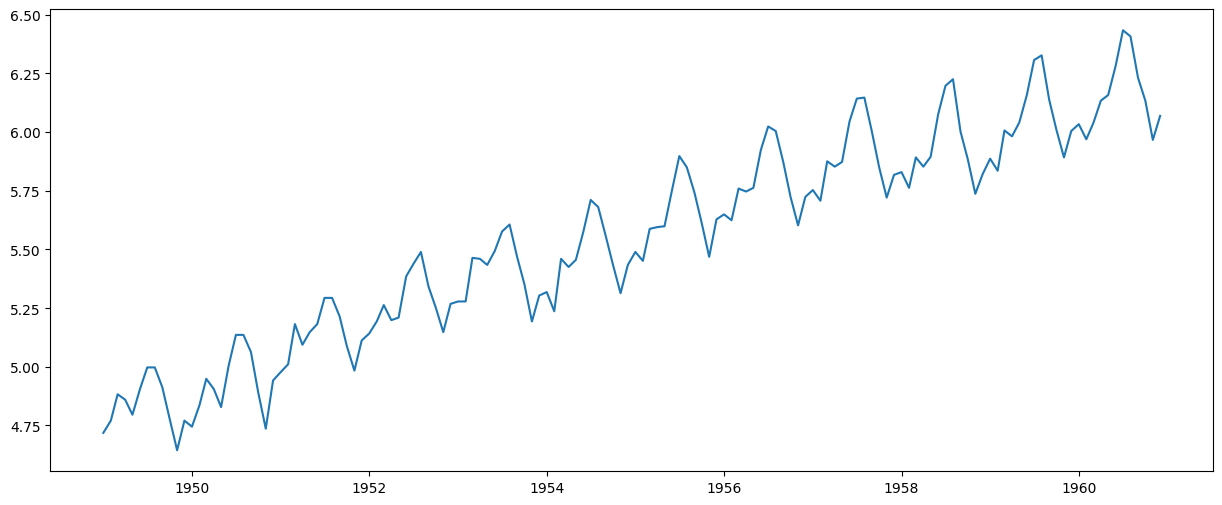

In [21]:
# Plot the log, it will look the same, but scale will be different
plt.plot(ts_log)

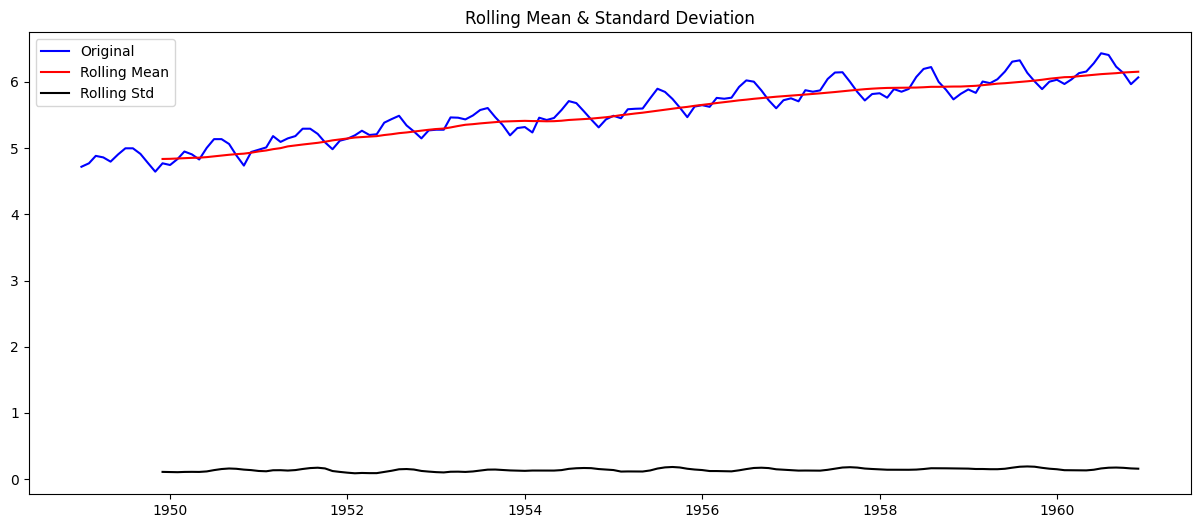

Results of Dickey-Fuller Test:
Test Statistics                 -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [22]:
test_stationarity(ts_log)

In [23]:
# Better, but still a long way to go

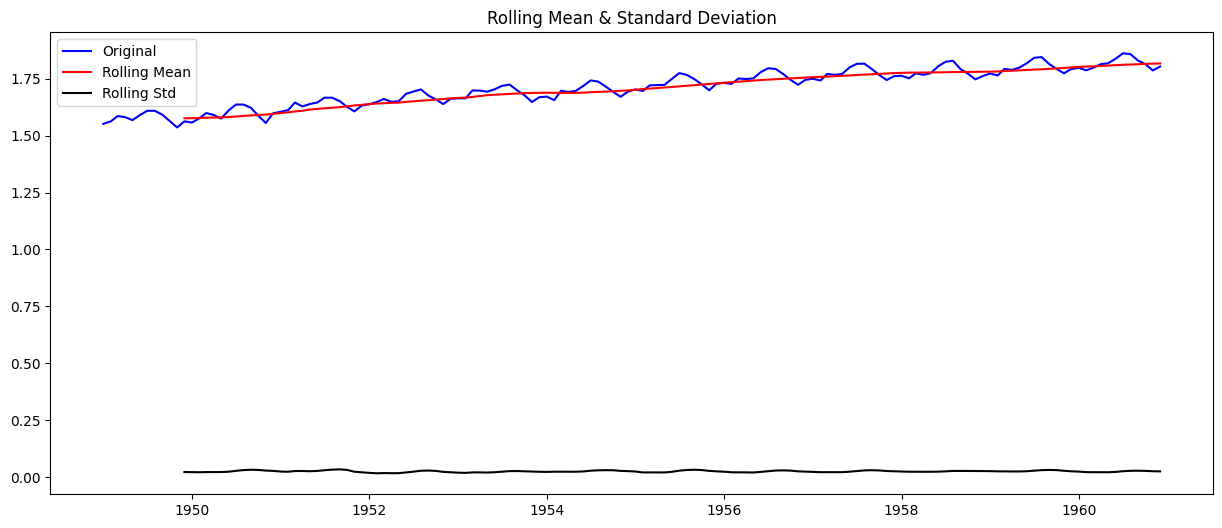

Results of Dickey-Fuller Test:
Test Statistics                 -2.156028
p-value                          0.222590
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [25]:
ts_doublelog = np.log(ts_log)
test_stationarity(ts_doublelog)

In [26]:
# Still not there

## Log + Moving Average + Differencing

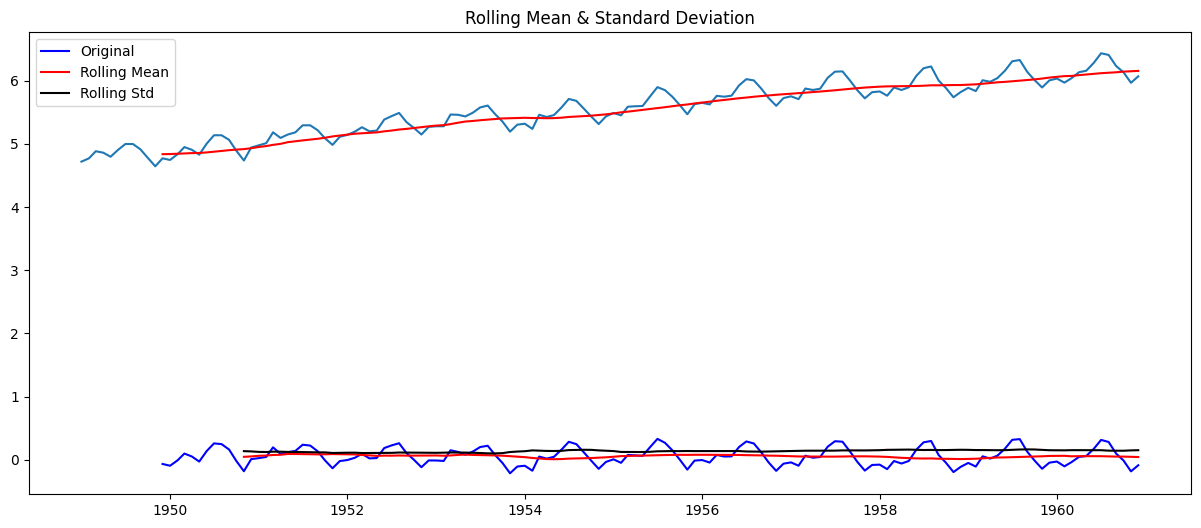

Results of Dickey-Fuller Test:
Test Statistics                 -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [30]:
# Smoothing
moving_avg = pd.Series(ts_log).rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

test_stationarity(ts_log_moving_avg_diff)

In [31]:
# P-value < 0.05
# Test Statistics is ~98% confidence.

## Exponential Weighted Avg

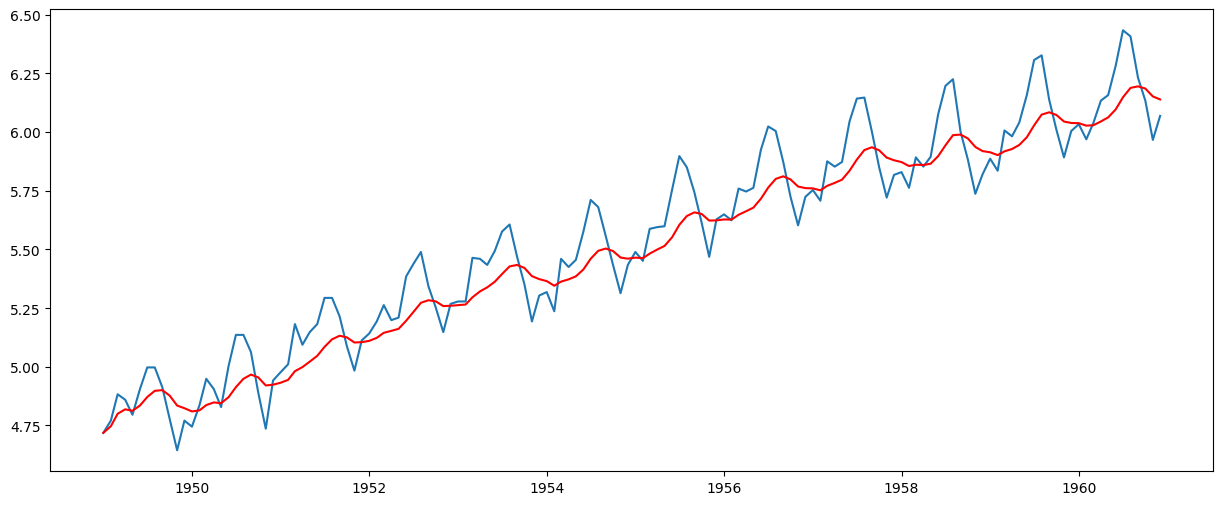

In [32]:
expweighted_avg = ts_log.ewm(span=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

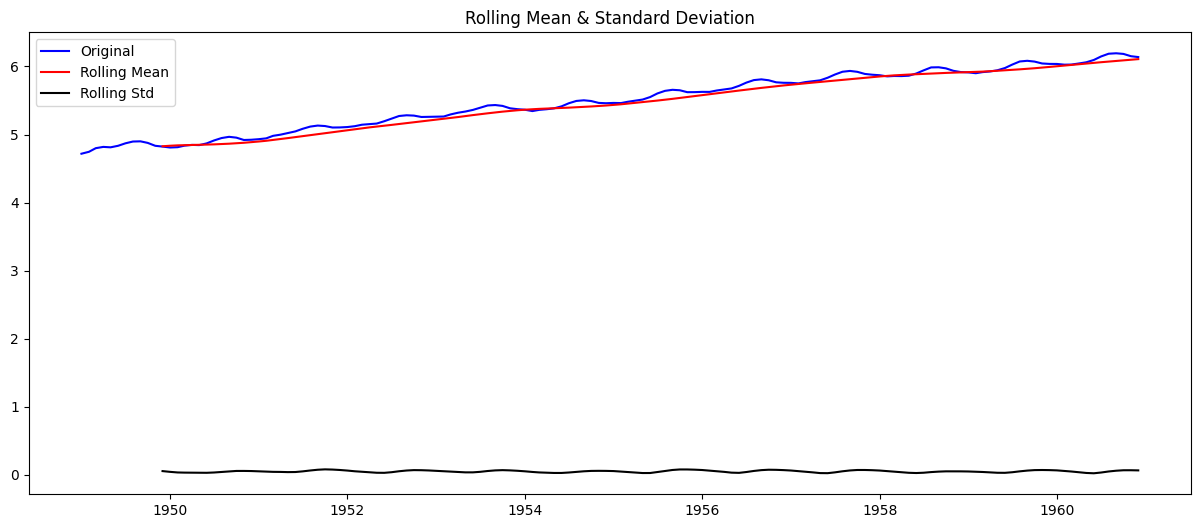

Results of Dickey-Fuller Test:
Test Statistics                 -2.477357
p-value                          0.121081
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [33]:
test_stationarity(expweighted_avg)

## Decomposition

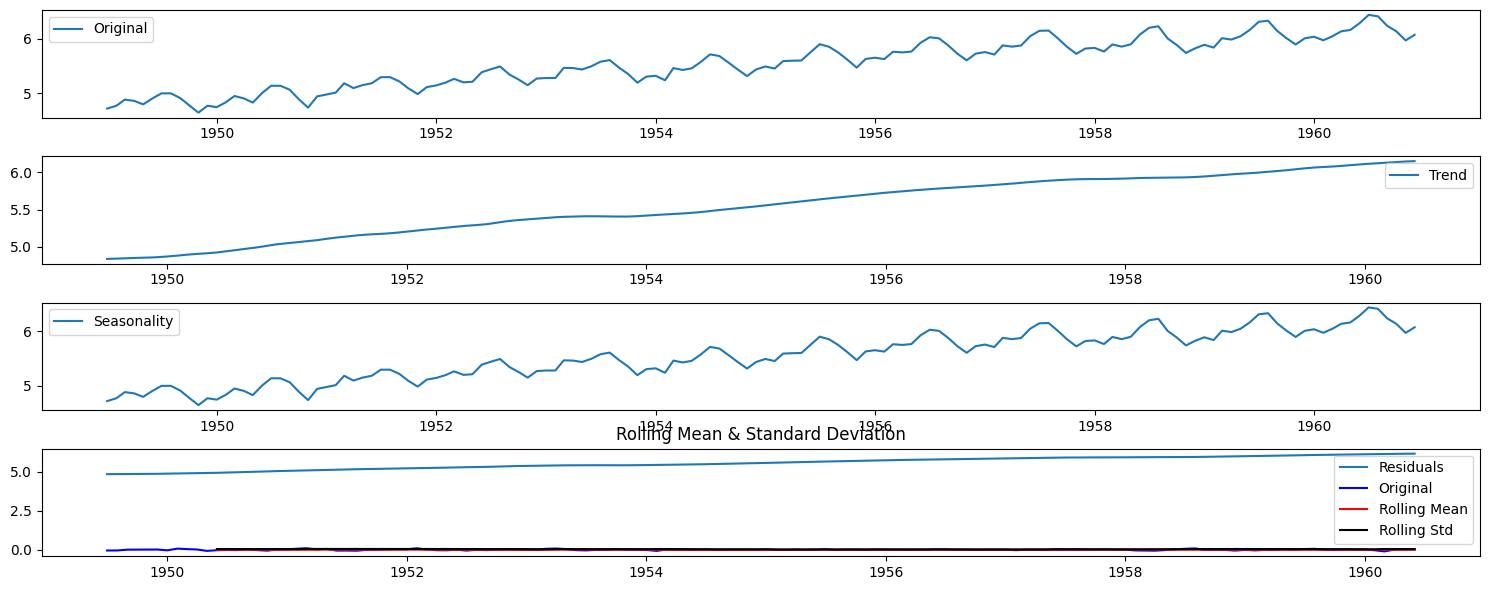

Results of Dickey-Fuller Test:
Test Statistics               -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_log, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(trend, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)